# Train a JointVAE model

In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import torch
from viz.visualize import Visualizer
use_cuda = torch.cuda.is_available()
use_cuda

True

In [15]:
use_cuda

True

In [16]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to your device

#### Prepare data list

In [17]:
!ls data

dress_dresslen_train_test_splits.json	dress_sleeve_train_test_splits.json
dress_sleevelen_train_test_splits.json


In [18]:
import json
with open("./data/dress_dresslen_train_test_splits.json", "r") as infile:
    data_dict = json.load(infile)

In [19]:
data_dict.keys()

dict_keys(['X_train_1', 'y_train_1', 'X_test_1', 'y_test_1', 'X_train_2', 'y_train_2', 'X_test_2', 'y_test_2', 'X_train_3', 'y_train_3', 'X_test_3', 'y_test_3', 'X_train_4', 'y_train_4', 'X_test_4', 'y_test_4', 'X_train_5', 'y_train_5', 'X_test_5', 'y_test_5', 'X_train_6', 'y_train_6', 'X_test_6', 'y_test_6', 'X_train_7', 'y_train_7', 'X_test_7', 'y_test_7', 'X_train_8', 'y_train_8', 'X_test_8', 'y_test_8', 'X_train_9', 'y_train_9', 'X_test_9', 'y_test_9', 'X_train_10', 'y_train_10', 'X_test_10', 'y_test_10'])

In [20]:
data_dict['X_train_1'][:5]

['/2/8/2893552_3773662.jpg',
 '/2/9/2982376_3889235.jpg',
 '/2/7/2783355_3578973.jpg',
 '/2/9/2974380_3918638.jpg',
 '/2/8/2886740_3675612.jpg']

#### Create list of image paths

In [21]:
!python -V

Python 3.6.3 :: Anaconda, Inc.


In [22]:
image_paths_train = []
image_paths_test = []

root_data_dir = "/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables"

for key, val in data_dict.items():
    if 'X_train' in key:
        image_paths_train.extend([root_data_dir + imgpath for imgpath in val])
    elif 'X_test' in key:
        image_paths_test.extend([root_data_dir + imgpath for imgpath in val])

print(f"Number of train image paths: {len(image_paths_train):,d}")
print(f"Number of test image paths: {len(image_paths_test):,d}")
print()
print("Sample paths:")
print(image_paths_train[0])
print(image_paths_train[-1])
print(image_paths_test[0])
print(image_paths_test[-1])

Number of train image paths: 167,742
Number of test image paths: 18,638

Sample paths:
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/8/2893552_3773662.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/6/2683298_3676896.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/4/2431229_3158108.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/5/2569101_3223742.jpg


In [23]:
#from utils.dataloaders import get_mnist_dataloaders, get_fashion_mnist_dataloaders
#train_loader, test_loader = get_mnist_dataloaders(batch_size=64)
#train_loader, test_loader = get_fashion_mnist_dataloaders(batch_size=64)

In [24]:
from torchvision import transforms
from utils.dataloaders_custom import get_imagelist_dataloader, ImageListDataset

#composed = transforms.Compose([transforms.Resize((260,260)), transforms.ToTensor()])
composed = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])

train_dataset = ImageListDataset(image_paths_train, transform=composed)
test_dataset = ImageListDataset(image_paths_test, transform=composed)

train_loader = get_imagelist_dataloader(batch_size=20, dataset_object=train_dataset)
test_loader = get_imagelist_dataloader(batch_size=20, dataset_object=test_dataset)

### Define latent distribution of the model

In [25]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 10,
               'disc': [10]}

### Build a model

In [26]:
#from jointvae.models_v1 import VAE
from jointvae.models import VAE

#model = VAE(latent_spec=latent_spec, img_size=(3, 260, 260), use_cuda=use_cuda)
model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64), use_cuda=use_cuda)

In [27]:
print(model)

VAE(
  (img_to_features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (features_to_hidden): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc_mean): Linear(in_features=256, out_features=10, bias=True)
  (fc_log_var): Linear(in_features=256, out_features=10, bias=True)
  (fc_alphas): ModuleList(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
  (latent_to_features): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
  )
  (features_to_img): Sequential(
    (0): ConvTranspose

### Train the model

In [28]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, amsgrad=True) # added amsgrad # orig lr 5e-4

In [29]:
from jointvae.training import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity,
                 use_cuda=use_cuda)

#### Initialize visualizer

In [30]:
# Build a visualizer which will be passed to trainer to visualize progress during training
viz = Visualizer(model)

In [31]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo

trainer.train(train_loader, epochs=200, save_training_gif=('./training_rd_308_64_200e_v1.gif', viz))

0/167742	Loss: 2776.650
1000/167742	Loss: 2394.200
2000/167742	Loss: 1490.457
3000/167742	Loss: 1388.712
4000/167742	Loss: 1377.599
5000/167742	Loss: 1347.805
6000/167742	Loss: 1359.986
7000/167742	Loss: 1322.137
8000/167742	Loss: 1328.284
9000/167742	Loss: 1309.065
10000/167742	Loss: 1338.004
11000/167742	Loss: 1298.892
12000/167742	Loss: 1302.248
13000/167742	Loss: 1292.436
14000/167742	Loss: 1288.961
15000/167742	Loss: 1279.462
16000/167742	Loss: 1264.345
17000/167742	Loss: 1272.750
18000/167742	Loss: 1268.310
19000/167742	Loss: 1248.455
20000/167742	Loss: 1261.820
21000/167742	Loss: 1268.755
22000/167742	Loss: 1255.233
23000/167742	Loss: 1243.324
24000/167742	Loss: 1244.678
25000/167742	Loss: 1249.922
26000/167742	Loss: 1242.560
27000/167742	Loss: 1236.872
28000/167742	Loss: 1252.023
29000/167742	Loss: 1244.712
30000/167742	Loss: 1212.802
31000/167742	Loss: 1219.299
32000/167742	Loss: 1233.910
33000/167742	Loss: 1215.865
34000/167742	Loss: 1229.535
35000/167742	Loss: 1236.695
36000

122000/167742	Loss: 1141.774
123000/167742	Loss: 1140.258
124000/167742	Loss: 1138.254
125000/167742	Loss: 1138.963
126000/167742	Loss: 1141.148
127000/167742	Loss: 1125.395
128000/167742	Loss: 1141.781
129000/167742	Loss: 1138.013
130000/167742	Loss: 1144.048
131000/167742	Loss: 1143.607
132000/167742	Loss: 1153.787
133000/167742	Loss: 1146.007
134000/167742	Loss: 1133.059
135000/167742	Loss: 1147.595
136000/167742	Loss: 1149.698
137000/167742	Loss: 1150.166
138000/167742	Loss: 1134.337
139000/167742	Loss: 1137.348
140000/167742	Loss: 1142.850
141000/167742	Loss: 1141.274
142000/167742	Loss: 1138.851
143000/167742	Loss: 1147.465
144000/167742	Loss: 1120.345
145000/167742	Loss: 1127.850
146000/167742	Loss: 1149.447
147000/167742	Loss: 1152.066
148000/167742	Loss: 1148.424
149000/167742	Loss: 1149.769
150000/167742	Loss: 1144.669
151000/167742	Loss: 1138.698
152000/167742	Loss: 1135.808
153000/167742	Loss: 1145.737
154000/167742	Loss: 1127.891
155000/167742	Loss: 1147.361
156000/167742	

74000/167742	Loss: 1127.604
75000/167742	Loss: 1102.840
76000/167742	Loss: 1110.059
77000/167742	Loss: 1125.361
78000/167742	Loss: 1120.768
79000/167742	Loss: 1114.697
80000/167742	Loss: 1118.496
81000/167742	Loss: 1106.070
82000/167742	Loss: 1133.506
83000/167742	Loss: 1118.939
84000/167742	Loss: 1123.652
85000/167742	Loss: 1129.381
86000/167742	Loss: 1126.298
87000/167742	Loss: 1114.553
88000/167742	Loss: 1101.963
89000/167742	Loss: 1111.856
90000/167742	Loss: 1107.500
91000/167742	Loss: 1136.283
92000/167742	Loss: 1117.913
93000/167742	Loss: 1118.486
94000/167742	Loss: 1115.669
95000/167742	Loss: 1110.490
96000/167742	Loss: 1122.332
97000/167742	Loss: 1111.769
98000/167742	Loss: 1119.796
99000/167742	Loss: 1114.584
100000/167742	Loss: 1135.358
101000/167742	Loss: 1117.688
102000/167742	Loss: 1122.146
103000/167742	Loss: 1111.575
104000/167742	Loss: 1129.973
105000/167742	Loss: 1129.955
106000/167742	Loss: 1126.129
107000/167742	Loss: 1115.044
108000/167742	Loss: 1119.180
109000/1677

25000/167742	Loss: 1105.798
26000/167742	Loss: 1116.422
27000/167742	Loss: 1112.671
28000/167742	Loss: 1130.253
29000/167742	Loss: 1109.935
30000/167742	Loss: 1106.061
31000/167742	Loss: 1123.800
32000/167742	Loss: 1114.503
33000/167742	Loss: 1108.395
34000/167742	Loss: 1131.950
35000/167742	Loss: 1117.048
36000/167742	Loss: 1117.967
37000/167742	Loss: 1094.239
38000/167742	Loss: 1108.166
39000/167742	Loss: 1105.263
40000/167742	Loss: 1114.625
41000/167742	Loss: 1119.204
42000/167742	Loss: 1132.214
43000/167742	Loss: 1101.805
44000/167742	Loss: 1107.661
45000/167742	Loss: 1118.891
46000/167742	Loss: 1128.171
47000/167742	Loss: 1097.130
48000/167742	Loss: 1105.160
49000/167742	Loss: 1097.473
50000/167742	Loss: 1108.472
51000/167742	Loss: 1115.602
52000/167742	Loss: 1103.519
53000/167742	Loss: 1130.415
54000/167742	Loss: 1106.352
55000/167742	Loss: 1121.881
56000/167742	Loss: 1114.410
57000/167742	Loss: 1116.020
58000/167742	Loss: 1101.765
59000/167742	Loss: 1117.470
60000/167742	Loss: 1

145000/167742	Loss: 1111.655
146000/167742	Loss: 1105.109
147000/167742	Loss: 1105.817
148000/167742	Loss: 1103.402
149000/167742	Loss: 1117.752
150000/167742	Loss: 1102.602
151000/167742	Loss: 1107.561
152000/167742	Loss: 1107.306
153000/167742	Loss: 1112.975
154000/167742	Loss: 1097.184
155000/167742	Loss: 1107.800
156000/167742	Loss: 1116.139
157000/167742	Loss: 1121.572
158000/167742	Loss: 1099.544
159000/167742	Loss: 1103.702
160000/167742	Loss: 1111.635
161000/167742	Loss: 1096.803
162000/167742	Loss: 1105.956
163000/167742	Loss: 1122.083
164000/167742	Loss: 1120.696
165000/167742	Loss: 1095.268
166000/167742	Loss: 1111.881
167000/167742	Loss: 1095.050
Epoch: 7 Average loss: 1110.29
0/167742	Loss: 1110.327
1000/167742	Loss: 1104.304
2000/167742	Loss: 1115.880
3000/167742	Loss: 1106.099
4000/167742	Loss: 1105.108
5000/167742	Loss: 1107.442
6000/167742	Loss: 1109.707
7000/167742	Loss: 1094.505
8000/167742	Loss: 1101.306
9000/167742	Loss: 1102.716
10000/167742	Loss: 1122.575
11000/1

98000/167742	Loss: 1098.519
99000/167742	Loss: 1098.455
100000/167742	Loss: 1115.109
101000/167742	Loss: 1107.962
102000/167742	Loss: 1114.675
103000/167742	Loss: 1107.044
104000/167742	Loss: 1102.678
105000/167742	Loss: 1100.052
106000/167742	Loss: 1103.616
107000/167742	Loss: 1096.937
108000/167742	Loss: 1095.577
109000/167742	Loss: 1106.442
110000/167742	Loss: 1115.480
111000/167742	Loss: 1094.946
112000/167742	Loss: 1097.791
113000/167742	Loss: 1102.268
114000/167742	Loss: 1102.790
115000/167742	Loss: 1099.757
116000/167742	Loss: 1103.093
117000/167742	Loss: 1086.206
118000/167742	Loss: 1116.478
119000/167742	Loss: 1114.836
120000/167742	Loss: 1093.280
121000/167742	Loss: 1090.854
122000/167742	Loss: 1082.849
123000/167742	Loss: 1099.129
124000/167742	Loss: 1100.675
125000/167742	Loss: 1101.228
126000/167742	Loss: 1109.369
127000/167742	Loss: 1105.126
128000/167742	Loss: 1103.702
129000/167742	Loss: 1112.174
130000/167742	Loss: 1104.817
131000/167742	Loss: 1092.111
132000/167742	Lo

49000/167742	Loss: 1107.097
50000/167742	Loss: 1115.129
51000/167742	Loss: 1084.913
52000/167742	Loss: 1120.376
53000/167742	Loss: 1099.549
54000/167742	Loss: 1095.549
55000/167742	Loss: 1113.982
56000/167742	Loss: 1097.934
57000/167742	Loss: 1099.048
58000/167742	Loss: 1118.971
59000/167742	Loss: 1089.446
60000/167742	Loss: 1108.064
61000/167742	Loss: 1089.272
62000/167742	Loss: 1095.721
63000/167742	Loss: 1092.871
64000/167742	Loss: 1092.123
65000/167742	Loss: 1100.823
66000/167742	Loss: 1097.186
67000/167742	Loss: 1099.917
68000/167742	Loss: 1103.493
69000/167742	Loss: 1093.612
70000/167742	Loss: 1109.070
71000/167742	Loss: 1102.289
72000/167742	Loss: 1089.283
73000/167742	Loss: 1097.527
74000/167742	Loss: 1106.840
75000/167742	Loss: 1109.960
76000/167742	Loss: 1097.458
77000/167742	Loss: 1091.871
78000/167742	Loss: 1099.904
79000/167742	Loss: 1098.180
80000/167742	Loss: 1103.083
81000/167742	Loss: 1083.046
82000/167742	Loss: 1098.317
83000/167742	Loss: 1095.085
84000/167742	Loss: 1

1000/167742	Loss: 1096.720
2000/167742	Loss: 1096.839
3000/167742	Loss: 1094.025
4000/167742	Loss: 1091.384
5000/167742	Loss: 1101.878
6000/167742	Loss: 1089.034
7000/167742	Loss: 1107.386
8000/167742	Loss: 1089.084
9000/167742	Loss: 1110.923
10000/167742	Loss: 1096.184
11000/167742	Loss: 1103.053
12000/167742	Loss: 1085.305
13000/167742	Loss: 1094.085
14000/167742	Loss: 1096.766
15000/167742	Loss: 1100.333
16000/167742	Loss: 1087.867
17000/167742	Loss: 1086.594
18000/167742	Loss: 1102.433
19000/167742	Loss: 1103.796
20000/167742	Loss: 1094.831
21000/167742	Loss: 1098.516
22000/167742	Loss: 1095.794
23000/167742	Loss: 1100.225
24000/167742	Loss: 1079.781
25000/167742	Loss: 1095.494
26000/167742	Loss: 1101.523
27000/167742	Loss: 1093.209
28000/167742	Loss: 1085.938
29000/167742	Loss: 1106.989
30000/167742	Loss: 1096.040
31000/167742	Loss: 1093.166
32000/167742	Loss: 1079.943
33000/167742	Loss: 1097.139
34000/167742	Loss: 1111.413
35000/167742	Loss: 1112.370
36000/167742	Loss: 1111.002
3

123000/167742	Loss: 1091.680
124000/167742	Loss: 1088.631
125000/167742	Loss: 1106.971
126000/167742	Loss: 1102.425
127000/167742	Loss: 1103.474
128000/167742	Loss: 1097.000
129000/167742	Loss: 1091.150
130000/167742	Loss: 1093.323
131000/167742	Loss: 1099.504
132000/167742	Loss: 1091.580
133000/167742	Loss: 1102.167
134000/167742	Loss: 1092.989
135000/167742	Loss: 1109.572
136000/167742	Loss: 1089.730
137000/167742	Loss: 1096.125
138000/167742	Loss: 1103.345
139000/167742	Loss: 1094.840
140000/167742	Loss: 1085.076
141000/167742	Loss: 1100.857
142000/167742	Loss: 1089.209
143000/167742	Loss: 1109.164
144000/167742	Loss: 1095.887
145000/167742	Loss: 1105.013
146000/167742	Loss: 1104.031
147000/167742	Loss: 1090.349
148000/167742	Loss: 1095.186
149000/167742	Loss: 1103.025
150000/167742	Loss: 1096.677
151000/167742	Loss: 1098.308
152000/167742	Loss: 1092.172
153000/167742	Loss: 1103.953
154000/167742	Loss: 1103.441
155000/167742	Loss: 1096.253
156000/167742	Loss: 1099.465
157000/167742	

75000/167742	Loss: 1088.801
76000/167742	Loss: 1104.360
77000/167742	Loss: 1091.656
78000/167742	Loss: 1110.553
79000/167742	Loss: 1085.623
80000/167742	Loss: 1103.378
81000/167742	Loss: 1104.978
82000/167742	Loss: 1098.791
83000/167742	Loss: 1096.561
84000/167742	Loss: 1093.522
85000/167742	Loss: 1096.628
86000/167742	Loss: 1091.045
87000/167742	Loss: 1092.312
88000/167742	Loss: 1089.281
89000/167742	Loss: 1119.655
90000/167742	Loss: 1097.396
91000/167742	Loss: 1099.984
92000/167742	Loss: 1102.687
93000/167742	Loss: 1098.679
94000/167742	Loss: 1095.215
95000/167742	Loss: 1095.159
96000/167742	Loss: 1082.935
97000/167742	Loss: 1088.247
98000/167742	Loss: 1087.646
99000/167742	Loss: 1101.009
100000/167742	Loss: 1082.443
101000/167742	Loss: 1100.962
102000/167742	Loss: 1087.825
103000/167742	Loss: 1091.426
104000/167742	Loss: 1084.190
105000/167742	Loss: 1096.399
106000/167742	Loss: 1111.059
107000/167742	Loss: 1084.089
108000/167742	Loss: 1094.230
109000/167742	Loss: 1089.451
110000/167

26000/167742	Loss: 1097.344
27000/167742	Loss: 1084.010
28000/167742	Loss: 1104.090
29000/167742	Loss: 1090.429
30000/167742	Loss: 1093.561
31000/167742	Loss: 1102.346
32000/167742	Loss: 1097.768
33000/167742	Loss: 1095.365
34000/167742	Loss: 1096.838
35000/167742	Loss: 1098.230
36000/167742	Loss: 1093.344
37000/167742	Loss: 1108.634
38000/167742	Loss: 1096.965
39000/167742	Loss: 1093.586
40000/167742	Loss: 1096.268
41000/167742	Loss: 1083.576
42000/167742	Loss: 1089.848
43000/167742	Loss: 1094.100
44000/167742	Loss: 1090.226
45000/167742	Loss: 1092.986
46000/167742	Loss: 1084.696
47000/167742	Loss: 1088.351
48000/167742	Loss: 1097.087
49000/167742	Loss: 1097.263
50000/167742	Loss: 1106.987
51000/167742	Loss: 1094.706
52000/167742	Loss: 1096.302
53000/167742	Loss: 1102.962
54000/167742	Loss: 1093.085
55000/167742	Loss: 1096.966
56000/167742	Loss: 1088.057
57000/167742	Loss: 1096.026
58000/167742	Loss: 1101.437
59000/167742	Loss: 1103.599
60000/167742	Loss: 1094.611
61000/167742	Loss: 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27000/167742	Loss: 1087.157
28000/167742	Loss: 1092.367
29000/167742	Loss: 1074.937
30000/167742	Loss: 1087.013
31000/167742	Loss: 1096.829
32000/167742	Loss: 1086.423
33000/167742	Loss: 1093.094
34000/167742	Loss: 1096.672
35000/167742	Loss: 1089.502
36000/167742	Loss: 1098.509
37000/167742	Loss: 1088.533
38000/167742	Loss: 1076.668
39000/167742	Loss: 1109.909
40000/167742	Loss: 1090.229
41000/167742	Loss: 1087.649
42000/167742	Loss: 1091.458
43000/167742	Loss: 1077.457
44000/167742	Loss: 1088.997
45000/167742	Loss: 1097.685
46000/167742	Loss: 1095.167
47000/167742	Loss: 1091.063
48000/167742	Loss: 1086.609
49000/167742	Loss: 1095.066
50000/167742	Loss: 1087.203
51000/167742	Loss: 1082.062
52000/167742	Loss: 1097.592
53000/167742	Loss: 1105.743
54000/167742	Loss: 1090.510
55000/167742	Loss: 1096.406
56000/167742	Loss: 1086.790
57000/167742	Loss: 1084.927
58000/167742	Loss: 1094.324
59000/167742	Loss: 1081.432
60000/167742	Loss: 1092.269
61000/167742	Loss: 1086.557
62000/167742	Loss: 1

74000/167742	Loss: 1086.592
75000/167742	Loss: 1090.350
76000/167742	Loss: 1069.090
77000/167742	Loss: 1084.829
78000/167742	Loss: 1100.390
79000/167742	Loss: 1090.851
80000/167742	Loss: 1078.497
81000/167742	Loss: 1089.968
82000/167742	Loss: 1093.599
83000/167742	Loss: 1088.040
84000/167742	Loss: 1084.983
85000/167742	Loss: 1085.667
86000/167742	Loss: 1093.324
87000/167742	Loss: 1086.004
88000/167742	Loss: 1073.620
89000/167742	Loss: 1091.508
90000/167742	Loss: 1096.299
91000/167742	Loss: 1087.229
92000/167742	Loss: 1079.140
93000/167742	Loss: 1077.324
94000/167742	Loss: 1090.433
95000/167742	Loss: 1095.195
96000/167742	Loss: 1085.345
97000/167742	Loss: 1090.872
98000/167742	Loss: 1080.717
99000/167742	Loss: 1084.641
100000/167742	Loss: 1086.117
101000/167742	Loss: 1096.734
102000/167742	Loss: 1085.317
103000/167742	Loss: 1073.565
104000/167742	Loss: 1077.677
105000/167742	Loss: 1094.742
106000/167742	Loss: 1092.976
107000/167742	Loss: 1081.415
108000/167742	Loss: 1074.545
109000/1677

25000/167742	Loss: 1084.195
26000/167742	Loss: 1092.247
27000/167742	Loss: 1085.266
28000/167742	Loss: 1069.869
29000/167742	Loss: 1084.241
30000/167742	Loss: 1085.361
31000/167742	Loss: 1078.161
32000/167742	Loss: 1080.380
33000/167742	Loss: 1080.367
34000/167742	Loss: 1094.042
35000/167742	Loss: 1084.859
36000/167742	Loss: 1079.258
37000/167742	Loss: 1084.682
38000/167742	Loss: 1083.784
39000/167742	Loss: 1086.961
40000/167742	Loss: 1090.205
41000/167742	Loss: 1074.543
42000/167742	Loss: 1087.382
43000/167742	Loss: 1088.033
44000/167742	Loss: 1086.238
45000/167742	Loss: 1084.219
46000/167742	Loss: 1079.634
47000/167742	Loss: 1074.084
48000/167742	Loss: 1092.879
49000/167742	Loss: 1086.020
50000/167742	Loss: 1095.972
51000/167742	Loss: 1069.463
52000/167742	Loss: 1086.662
53000/167742	Loss: 1100.272
54000/167742	Loss: 1082.305
55000/167742	Loss: 1081.129
56000/167742	Loss: 1074.270
57000/167742	Loss: 1094.339
58000/167742	Loss: 1089.962
59000/167742	Loss: 1082.656
60000/167742	Loss: 1

145000/167742	Loss: 1082.192
146000/167742	Loss: 1074.321
147000/167742	Loss: 1084.807
148000/167742	Loss: 1077.870
149000/167742	Loss: 1091.266
150000/167742	Loss: 1081.780
151000/167742	Loss: 1095.093
152000/167742	Loss: 1081.297
153000/167742	Loss: 1083.828
154000/167742	Loss: 1070.678
155000/167742	Loss: 1083.594
156000/167742	Loss: 1090.966
157000/167742	Loss: 1082.377
158000/167742	Loss: 1083.644
159000/167742	Loss: 1081.079
160000/167742	Loss: 1092.712
161000/167742	Loss: 1077.700
162000/167742	Loss: 1091.503
163000/167742	Loss: 1085.283
164000/167742	Loss: 1092.095
165000/167742	Loss: 1077.924
166000/167742	Loss: 1076.840
167000/167742	Loss: 1083.242
Epoch: 111 Average loss: 1085.08
0/167742	Loss: 1051.996
1000/167742	Loss: 1072.441
2000/167742	Loss: 1087.070
3000/167742	Loss: 1086.272
4000/167742	Loss: 1085.914
5000/167742	Loss: 1087.520
6000/167742	Loss: 1081.079
7000/167742	Loss: 1085.417
8000/167742	Loss: 1088.573
9000/167742	Loss: 1068.545
10000/167742	Loss: 1099.087
11000

97000/167742	Loss: 1085.961
98000/167742	Loss: 1088.446
99000/167742	Loss: 1089.326
100000/167742	Loss: 1085.446
101000/167742	Loss: 1078.447
102000/167742	Loss: 1075.919
103000/167742	Loss: 1086.752
104000/167742	Loss: 1098.477
105000/167742	Loss: 1076.842
106000/167742	Loss: 1095.230
107000/167742	Loss: 1079.716
108000/167742	Loss: 1081.375
109000/167742	Loss: 1097.607
110000/167742	Loss: 1075.940
111000/167742	Loss: 1077.909
112000/167742	Loss: 1073.069
113000/167742	Loss: 1079.343
114000/167742	Loss: 1076.861
115000/167742	Loss: 1094.133
116000/167742	Loss: 1086.110
117000/167742	Loss: 1090.882
118000/167742	Loss: 1086.469
119000/167742	Loss: 1068.417
120000/167742	Loss: 1088.641
121000/167742	Loss: 1082.977
122000/167742	Loss: 1094.453
123000/167742	Loss: 1099.178
124000/167742	Loss: 1082.524
125000/167742	Loss: 1074.997
126000/167742	Loss: 1080.673
127000/167742	Loss: 1088.587
128000/167742	Loss: 1085.782
129000/167742	Loss: 1077.043
130000/167742	Loss: 1098.124
131000/167742	Los

48000/167742	Loss: 1092.103
49000/167742	Loss: 1075.153
50000/167742	Loss: 1095.121
51000/167742	Loss: 1086.917
52000/167742	Loss: 1076.340
53000/167742	Loss: 1088.225
54000/167742	Loss: 1068.586
55000/167742	Loss: 1069.415
56000/167742	Loss: 1100.904
57000/167742	Loss: 1089.628
58000/167742	Loss: 1079.299
59000/167742	Loss: 1084.982
60000/167742	Loss: 1083.275
61000/167742	Loss: 1063.526
62000/167742	Loss: 1070.362
63000/167742	Loss: 1087.564
64000/167742	Loss: 1091.933
65000/167742	Loss: 1088.845
66000/167742	Loss: 1077.209
67000/167742	Loss: 1088.849
68000/167742	Loss: 1077.703
69000/167742	Loss: 1079.671
70000/167742	Loss: 1086.940
71000/167742	Loss: 1079.006
72000/167742	Loss: 1093.792
73000/167742	Loss: 1073.555
74000/167742	Loss: 1080.603
75000/167742	Loss: 1077.946
76000/167742	Loss: 1089.362
77000/167742	Loss: 1095.341
78000/167742	Loss: 1077.668
79000/167742	Loss: 1087.511
80000/167742	Loss: 1089.524
81000/167742	Loss: 1076.470
82000/167742	Loss: 1076.189
83000/167742	Loss: 1

Epoch: 116 Average loss: 1084.89
0/167742	Loss: 1090.107
1000/167742	Loss: 1075.498
2000/167742	Loss: 1088.044
3000/167742	Loss: 1072.286
4000/167742	Loss: 1087.362
5000/167742	Loss: 1088.789
6000/167742	Loss: 1080.844
7000/167742	Loss: 1084.372
8000/167742	Loss: 1096.953
9000/167742	Loss: 1096.675
10000/167742	Loss: 1079.614
11000/167742	Loss: 1090.227
12000/167742	Loss: 1087.481
13000/167742	Loss: 1079.503
14000/167742	Loss: 1091.981
15000/167742	Loss: 1076.592
16000/167742	Loss: 1096.394
17000/167742	Loss: 1083.099
18000/167742	Loss: 1096.149
19000/167742	Loss: 1076.668
20000/167742	Loss: 1086.676
21000/167742	Loss: 1080.379
22000/167742	Loss: 1092.040
23000/167742	Loss: 1085.113
24000/167742	Loss: 1074.964
25000/167742	Loss: 1097.816
26000/167742	Loss: 1087.126
27000/167742	Loss: 1095.793
28000/167742	Loss: 1083.264
29000/167742	Loss: 1082.459
30000/167742	Loss: 1090.335
31000/167742	Loss: 1079.236
32000/167742	Loss: 1069.840
33000/167742	Loss: 1083.460
34000/167742	Loss: 1090.809


121000/167742	Loss: 1087.115
122000/167742	Loss: 1080.237
123000/167742	Loss: 1086.842
124000/167742	Loss: 1071.747
125000/167742	Loss: 1077.256
126000/167742	Loss: 1087.246
127000/167742	Loss: 1094.415
128000/167742	Loss: 1084.872
129000/167742	Loss: 1096.180
130000/167742	Loss: 1081.071
131000/167742	Loss: 1077.072
132000/167742	Loss: 1091.453
133000/167742	Loss: 1088.220
134000/167742	Loss: 1071.106
135000/167742	Loss: 1081.645
136000/167742	Loss: 1090.480
137000/167742	Loss: 1081.906
138000/167742	Loss: 1084.542
139000/167742	Loss: 1090.288
140000/167742	Loss: 1069.068
141000/167742	Loss: 1086.718
142000/167742	Loss: 1087.205
143000/167742	Loss: 1078.465
144000/167742	Loss: 1082.022
145000/167742	Loss: 1074.163
146000/167742	Loss: 1084.485
147000/167742	Loss: 1088.225
148000/167742	Loss: 1092.149
149000/167742	Loss: 1086.080
150000/167742	Loss: 1079.916
151000/167742	Loss: 1081.104
152000/167742	Loss: 1089.293
153000/167742	Loss: 1076.771
154000/167742	Loss: 1073.344
155000/167742	

73000/167742	Loss: 1079.992
74000/167742	Loss: 1089.603
75000/167742	Loss: 1077.059
76000/167742	Loss: 1063.093
77000/167742	Loss: 1081.355
78000/167742	Loss: 1080.826
79000/167742	Loss: 1077.527
80000/167742	Loss: 1084.872
81000/167742	Loss: 1095.018
82000/167742	Loss: 1083.424
83000/167742	Loss: 1085.018
84000/167742	Loss: 1078.309
85000/167742	Loss: 1085.884
86000/167742	Loss: 1077.957
87000/167742	Loss: 1078.543
88000/167742	Loss: 1092.635
89000/167742	Loss: 1079.768
90000/167742	Loss: 1084.918
91000/167742	Loss: 1092.836
92000/167742	Loss: 1077.971
93000/167742	Loss: 1077.706
94000/167742	Loss: 1083.285
95000/167742	Loss: 1083.349
96000/167742	Loss: 1075.639
97000/167742	Loss: 1081.533
98000/167742	Loss: 1088.174
99000/167742	Loss: 1083.162
100000/167742	Loss: 1072.603
101000/167742	Loss: 1094.936
102000/167742	Loss: 1093.981
103000/167742	Loss: 1081.206
104000/167742	Loss: 1077.506
105000/167742	Loss: 1078.664
106000/167742	Loss: 1073.377
107000/167742	Loss: 1067.480
108000/16774

24000/167742	Loss: 1080.831
25000/167742	Loss: 1086.061
26000/167742	Loss: 1083.667
27000/167742	Loss: 1090.650
28000/167742	Loss: 1102.449
29000/167742	Loss: 1091.858
30000/167742	Loss: 1086.482
31000/167742	Loss: 1084.029
32000/167742	Loss: 1067.785
33000/167742	Loss: 1076.420
34000/167742	Loss: 1080.299
35000/167742	Loss: 1091.072
36000/167742	Loss: 1077.062
37000/167742	Loss: 1089.438
38000/167742	Loss: 1091.811
39000/167742	Loss: 1090.177
40000/167742	Loss: 1090.122
41000/167742	Loss: 1091.690
42000/167742	Loss: 1070.901
43000/167742	Loss: 1070.904
44000/167742	Loss: 1102.780
45000/167742	Loss: 1075.246
46000/167742	Loss: 1092.149
47000/167742	Loss: 1089.088
48000/167742	Loss: 1082.403
49000/167742	Loss: 1080.155
50000/167742	Loss: 1087.660
51000/167742	Loss: 1079.485
52000/167742	Loss: 1086.489
53000/167742	Loss: 1093.231
54000/167742	Loss: 1076.807
55000/167742	Loss: 1092.248
56000/167742	Loss: 1060.015
57000/167742	Loss: 1078.870
58000/167742	Loss: 1075.525
59000/167742	Loss: 1

144000/167742	Loss: 1087.959
145000/167742	Loss: 1076.297
146000/167742	Loss: 1079.124
147000/167742	Loss: 1087.401
148000/167742	Loss: 1091.210
149000/167742	Loss: 1090.731
150000/167742	Loss: 1074.580
151000/167742	Loss: 1078.714
152000/167742	Loss: 1089.605
153000/167742	Loss: 1078.462
154000/167742	Loss: 1084.415
155000/167742	Loss: 1089.724
156000/167742	Loss: 1092.693
157000/167742	Loss: 1086.332
158000/167742	Loss: 1073.580
159000/167742	Loss: 1080.664
160000/167742	Loss: 1085.315
161000/167742	Loss: 1077.893
162000/167742	Loss: 1085.205
163000/167742	Loss: 1057.998
164000/167742	Loss: 1078.554
165000/167742	Loss: 1081.821
166000/167742	Loss: 1094.052
167000/167742	Loss: 1095.119
Epoch: 123 Average loss: 1084.75
0/167742	Loss: 1023.017
1000/167742	Loss: 1079.690
2000/167742	Loss: 1071.055
3000/167742	Loss: 1092.430
4000/167742	Loss: 1085.787
5000/167742	Loss: 1087.124
6000/167742	Loss: 1078.974
7000/167742	Loss: 1082.486
8000/167742	Loss: 1080.155
9000/167742	Loss: 1092.920
1000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



96000/167742	Loss: 1083.031
97000/167742	Loss: 1074.964
98000/167742	Loss: 1082.511
99000/167742	Loss: 1086.115
100000/167742	Loss: 1087.356
101000/167742	Loss: 1093.575
102000/167742	Loss: 1081.984
103000/167742	Loss: 1081.355
104000/167742	Loss: 1088.801
105000/167742	Loss: 1095.619
106000/167742	Loss: 1091.949
107000/167742	Loss: 1089.332
108000/167742	Loss: 1087.133
109000/167742	Loss: 1074.161
110000/167742	Loss: 1080.813
111000/167742	Loss: 1075.355
112000/167742	Loss: 1089.223
113000/167742	Loss: 1084.528
114000/167742	Loss: 1081.575
115000/167742	Loss: 1081.510
116000/167742	Loss: 1071.382
117000/167742	Loss: 1095.288
118000/167742	Loss: 1077.717
119000/167742	Loss: 1100.053
120000/167742	Loss: 1082.728
121000/167742	Loss: 1078.107
122000/167742	Loss: 1072.952
123000/167742	Loss: 1097.729
124000/167742	Loss: 1077.383
125000/167742	Loss: 1083.982
126000/167742	Loss: 1067.137
127000/167742	Loss: 1082.210
128000/167742	Loss: 1071.576
129000/167742	Loss: 1087.503
130000/167742	Loss

47000/167742	Loss: 1075.944
48000/167742	Loss: 1083.171
49000/167742	Loss: 1088.389
50000/167742	Loss: 1087.113
51000/167742	Loss: 1096.365
52000/167742	Loss: 1083.119
53000/167742	Loss: 1082.575
54000/167742	Loss: 1085.977
55000/167742	Loss: 1094.979
56000/167742	Loss: 1095.341
57000/167742	Loss: 1069.885
58000/167742	Loss: 1087.333
59000/167742	Loss: 1087.576
60000/167742	Loss: 1096.843
61000/167742	Loss: 1084.508
62000/167742	Loss: 1083.742
63000/167742	Loss: 1080.478
64000/167742	Loss: 1092.537
65000/167742	Loss: 1080.414
66000/167742	Loss: 1083.085
67000/167742	Loss: 1083.940
68000/167742	Loss: 1089.010
69000/167742	Loss: 1094.944
70000/167742	Loss: 1081.865
71000/167742	Loss: 1087.390
72000/167742	Loss: 1075.837
73000/167742	Loss: 1089.289
74000/167742	Loss: 1071.034
75000/167742	Loss: 1092.275
76000/167742	Loss: 1088.517
77000/167742	Loss: 1074.536
78000/167742	Loss: 1080.458
79000/167742	Loss: 1085.150
80000/167742	Loss: 1094.054
81000/167742	Loss: 1085.187
82000/167742	Loss: 1

167000/167742	Loss: 1088.305
Epoch: 152 Average loss: 1083.74
0/167742	Loss: 998.424
1000/167742	Loss: 1074.144
2000/167742	Loss: 1080.610
3000/167742	Loss: 1086.851
4000/167742	Loss: 1081.709
5000/167742	Loss: 1092.543
6000/167742	Loss: 1083.613
7000/167742	Loss: 1085.614
8000/167742	Loss: 1080.663
9000/167742	Loss: 1086.229
10000/167742	Loss: 1080.922
11000/167742	Loss: 1097.803
12000/167742	Loss: 1070.106
13000/167742	Loss: 1087.356
14000/167742	Loss: 1077.839
15000/167742	Loss: 1083.545
16000/167742	Loss: 1097.406
17000/167742	Loss: 1083.825
18000/167742	Loss: 1084.772
19000/167742	Loss: 1075.980
20000/167742	Loss: 1076.700
21000/167742	Loss: 1074.308
22000/167742	Loss: 1084.310
23000/167742	Loss: 1091.849
24000/167742	Loss: 1073.144
25000/167742	Loss: 1090.944
26000/167742	Loss: 1082.078
27000/167742	Loss: 1078.919
28000/167742	Loss: 1081.792
29000/167742	Loss: 1087.021
30000/167742	Loss: 1089.598
31000/167742	Loss: 1086.906
32000/167742	Loss: 1086.245
33000/167742	Loss: 1085.410


120000/167742	Loss: 1083.880
121000/167742	Loss: 1066.557
122000/167742	Loss: 1087.498
123000/167742	Loss: 1069.449
124000/167742	Loss: 1089.428
125000/167742	Loss: 1082.169
126000/167742	Loss: 1090.256
127000/167742	Loss: 1070.718
128000/167742	Loss: 1081.130
129000/167742	Loss: 1075.074
130000/167742	Loss: 1072.008
131000/167742	Loss: 1086.243
132000/167742	Loss: 1078.374
133000/167742	Loss: 1095.196
134000/167742	Loss: 1082.268
135000/167742	Loss: 1092.389
136000/167742	Loss: 1085.074
137000/167742	Loss: 1086.683
138000/167742	Loss: 1101.346
139000/167742	Loss: 1084.038
140000/167742	Loss: 1074.547
141000/167742	Loss: 1081.809
142000/167742	Loss: 1079.852
143000/167742	Loss: 1087.674
144000/167742	Loss: 1095.148
145000/167742	Loss: 1081.319
146000/167742	Loss: 1093.742
147000/167742	Loss: 1091.358
148000/167742	Loss: 1081.489
149000/167742	Loss: 1097.384
150000/167742	Loss: 1085.612
151000/167742	Loss: 1087.651
152000/167742	Loss: 1077.822
153000/167742	Loss: 1077.057
154000/167742	

72000/167742	Loss: 1087.689
73000/167742	Loss: 1073.970
74000/167742	Loss: 1081.593
75000/167742	Loss: 1074.803
76000/167742	Loss: 1082.972
77000/167742	Loss: 1083.313
78000/167742	Loss: 1081.751
79000/167742	Loss: 1082.923
80000/167742	Loss: 1068.418
81000/167742	Loss: 1092.931
82000/167742	Loss: 1082.956
83000/167742	Loss: 1102.749
84000/167742	Loss: 1080.621
85000/167742	Loss: 1090.927
86000/167742	Loss: 1088.282
87000/167742	Loss: 1087.283
88000/167742	Loss: 1082.105
89000/167742	Loss: 1082.110
90000/167742	Loss: 1087.050
91000/167742	Loss: 1081.771
92000/167742	Loss: 1090.854
93000/167742	Loss: 1084.938
94000/167742	Loss: 1090.829
95000/167742	Loss: 1101.462
96000/167742	Loss: 1096.260
97000/167742	Loss: 1093.701
98000/167742	Loss: 1074.310
99000/167742	Loss: 1102.982
100000/167742	Loss: 1083.091
101000/167742	Loss: 1081.538
102000/167742	Loss: 1080.386
103000/167742	Loss: 1081.918
104000/167742	Loss: 1083.233
105000/167742	Loss: 1087.544
106000/167742	Loss: 1077.799
107000/167742

23000/167742	Loss: 1083.536
24000/167742	Loss: 1076.582
25000/167742	Loss: 1080.883
26000/167742	Loss: 1094.443
27000/167742	Loss: 1095.933
28000/167742	Loss: 1080.355
29000/167742	Loss: 1076.655
30000/167742	Loss: 1095.355
31000/167742	Loss: 1087.777
32000/167742	Loss: 1091.934
33000/167742	Loss: 1077.277
34000/167742	Loss: 1078.099
35000/167742	Loss: 1082.612
36000/167742	Loss: 1073.187
37000/167742	Loss: 1091.637
38000/167742	Loss: 1079.570
39000/167742	Loss: 1080.799
40000/167742	Loss: 1078.334
41000/167742	Loss: 1095.041
42000/167742	Loss: 1071.233
43000/167742	Loss: 1082.554
44000/167742	Loss: 1077.304
45000/167742	Loss: 1100.535
46000/167742	Loss: 1073.353
47000/167742	Loss: 1095.952
48000/167742	Loss: 1086.963
49000/167742	Loss: 1089.243
50000/167742	Loss: 1081.907
51000/167742	Loss: 1082.183
52000/167742	Loss: 1098.211
53000/167742	Loss: 1090.676
54000/167742	Loss: 1074.333
55000/167742	Loss: 1078.892
56000/167742	Loss: 1077.267
57000/167742	Loss: 1084.519
58000/167742	Loss: 1

143000/167742	Loss: 1085.969
144000/167742	Loss: 1073.003
145000/167742	Loss: 1074.925
146000/167742	Loss: 1087.930
147000/167742	Loss: 1087.031
148000/167742	Loss: 1088.918
149000/167742	Loss: 1098.964
150000/167742	Loss: 1098.475
151000/167742	Loss: 1090.332
152000/167742	Loss: 1087.565
153000/167742	Loss: 1072.041
154000/167742	Loss: 1094.627
155000/167742	Loss: 1087.219
156000/167742	Loss: 1085.109
157000/167742	Loss: 1082.617
158000/167742	Loss: 1085.027
159000/167742	Loss: 1091.350
160000/167742	Loss: 1080.655
161000/167742	Loss: 1090.465
162000/167742	Loss: 1081.029
163000/167742	Loss: 1082.095
164000/167742	Loss: 1090.431
165000/167742	Loss: 1087.925
166000/167742	Loss: 1087.909
167000/167742	Loss: 1077.030
Epoch: 159 Average loss: 1083.86
0/167742	Loss: 1139.418
1000/167742	Loss: 1087.578
2000/167742	Loss: 1073.847
3000/167742	Loss: 1078.631
4000/167742	Loss: 1063.870
5000/167742	Loss: 1073.319
6000/167742	Loss: 1070.109
7000/167742	Loss: 1087.304
8000/167742	Loss: 1076.536
90

95000/167742	Loss: 1085.899
96000/167742	Loss: 1089.646
97000/167742	Loss: 1060.488
98000/167742	Loss: 1084.781
99000/167742	Loss: 1073.814
100000/167742	Loss: 1070.130
101000/167742	Loss: 1090.974
102000/167742	Loss: 1098.201
103000/167742	Loss: 1074.328
104000/167742	Loss: 1086.310
105000/167742	Loss: 1080.088
106000/167742	Loss: 1077.617
107000/167742	Loss: 1085.980
108000/167742	Loss: 1078.125
109000/167742	Loss: 1083.850
110000/167742	Loss: 1071.919
111000/167742	Loss: 1079.141
112000/167742	Loss: 1089.468
113000/167742	Loss: 1093.114
114000/167742	Loss: 1088.770
115000/167742	Loss: 1079.480
116000/167742	Loss: 1090.803
117000/167742	Loss: 1083.636
118000/167742	Loss: 1076.169
119000/167742	Loss: 1096.425
120000/167742	Loss: 1094.560
121000/167742	Loss: 1081.323
122000/167742	Loss: 1086.718
123000/167742	Loss: 1081.292
124000/167742	Loss: 1075.220
125000/167742	Loss: 1072.742
126000/167742	Loss: 1091.010
127000/167742	Loss: 1076.510
128000/167742	Loss: 1085.020
129000/167742	Loss:

46000/167742	Loss: 1078.875
47000/167742	Loss: 1090.527
48000/167742	Loss: 1100.187
49000/167742	Loss: 1078.536
50000/167742	Loss: 1090.035
51000/167742	Loss: 1077.961
52000/167742	Loss: 1088.885
53000/167742	Loss: 1077.143
54000/167742	Loss: 1075.060
55000/167742	Loss: 1089.415
56000/167742	Loss: 1084.166
57000/167742	Loss: 1088.776
58000/167742	Loss: 1073.588
59000/167742	Loss: 1074.492
60000/167742	Loss: 1081.182
61000/167742	Loss: 1087.533
62000/167742	Loss: 1092.596
63000/167742	Loss: 1103.086
64000/167742	Loss: 1076.489
65000/167742	Loss: 1079.110
66000/167742	Loss: 1067.446
67000/167742	Loss: 1082.574
68000/167742	Loss: 1082.826
69000/167742	Loss: 1078.543
70000/167742	Loss: 1082.255
71000/167742	Loss: 1087.051
72000/167742	Loss: 1079.157
73000/167742	Loss: 1087.928
74000/167742	Loss: 1100.118
75000/167742	Loss: 1087.220
76000/167742	Loss: 1082.621
77000/167742	Loss: 1073.612
78000/167742	Loss: 1082.676
79000/167742	Loss: 1100.155
80000/167742	Loss: 1088.758
81000/167742	Loss: 1

166000/167742	Loss: 1075.140
167000/167742	Loss: 1087.324
Epoch: 164 Average loss: 1083.64
0/167742	Loss: 923.854
1000/167742	Loss: 1086.985
2000/167742	Loss: 1093.300
3000/167742	Loss: 1084.902
4000/167742	Loss: 1078.405
5000/167742	Loss: 1091.917
6000/167742	Loss: 1080.080
7000/167742	Loss: 1095.878
8000/167742	Loss: 1084.126
9000/167742	Loss: 1079.556
10000/167742	Loss: 1077.902
11000/167742	Loss: 1084.859
12000/167742	Loss: 1073.023
13000/167742	Loss: 1074.693
14000/167742	Loss: 1086.364
15000/167742	Loss: 1088.248
16000/167742	Loss: 1075.507
17000/167742	Loss: 1086.655
18000/167742	Loss: 1087.436
19000/167742	Loss: 1087.564
20000/167742	Loss: 1095.120
21000/167742	Loss: 1068.913
22000/167742	Loss: 1080.219
23000/167742	Loss: 1082.518
24000/167742	Loss: 1070.735
25000/167742	Loss: 1068.909
26000/167742	Loss: 1081.326
27000/167742	Loss: 1095.997
28000/167742	Loss: 1083.266
29000/167742	Loss: 1082.932
30000/167742	Loss: 1086.157
31000/167742	Loss: 1079.845
32000/167742	Loss: 1075.300

119000/167742	Loss: 1083.332
120000/167742	Loss: 1080.492
121000/167742	Loss: 1085.029
122000/167742	Loss: 1091.634
123000/167742	Loss: 1065.715
124000/167742	Loss: 1095.268
125000/167742	Loss: 1082.161
126000/167742	Loss: 1087.482
127000/167742	Loss: 1080.286
128000/167742	Loss: 1090.450
129000/167742	Loss: 1086.943
130000/167742	Loss: 1075.524
131000/167742	Loss: 1094.705
132000/167742	Loss: 1075.553
133000/167742	Loss: 1088.614
134000/167742	Loss: 1089.471
135000/167742	Loss: 1089.331
136000/167742	Loss: 1079.883
137000/167742	Loss: 1088.323
138000/167742	Loss: 1080.283
139000/167742	Loss: 1083.948
140000/167742	Loss: 1085.540
141000/167742	Loss: 1083.906
142000/167742	Loss: 1077.855
143000/167742	Loss: 1095.456
144000/167742	Loss: 1066.408
145000/167742	Loss: 1073.164
146000/167742	Loss: 1098.969
147000/167742	Loss: 1071.644
148000/167742	Loss: 1088.500
149000/167742	Loss: 1084.583
150000/167742	Loss: 1085.818
151000/167742	Loss: 1058.702
152000/167742	Loss: 1088.262
153000/167742	

70000/167742	Loss: 1093.067
71000/167742	Loss: 1093.585
72000/167742	Loss: 1080.231
73000/167742	Loss: 1074.955
74000/167742	Loss: 1072.678
75000/167742	Loss: 1096.136
76000/167742	Loss: 1084.290
77000/167742	Loss: 1093.209
78000/167742	Loss: 1089.829
79000/167742	Loss: 1089.973
80000/167742	Loss: 1093.366
81000/167742	Loss: 1080.906
82000/167742	Loss: 1079.580
83000/167742	Loss: 1078.420
84000/167742	Loss: 1072.519
85000/167742	Loss: 1064.516
86000/167742	Loss: 1082.392
87000/167742	Loss: 1081.125
88000/167742	Loss: 1087.711
89000/167742	Loss: 1082.063
90000/167742	Loss: 1070.958
91000/167742	Loss: 1090.747
92000/167742	Loss: 1089.644
93000/167742	Loss: 1091.552
94000/167742	Loss: 1089.526
95000/167742	Loss: 1091.694
96000/167742	Loss: 1083.178
97000/167742	Loss: 1086.407
98000/167742	Loss: 1087.280
99000/167742	Loss: 1091.270
100000/167742	Loss: 1080.732
101000/167742	Loss: 1077.222
102000/167742	Loss: 1083.622
103000/167742	Loss: 1081.544
104000/167742	Loss: 1072.247
105000/167742	L

21000/167742	Loss: 1078.631
22000/167742	Loss: 1086.918
23000/167742	Loss: 1085.204
24000/167742	Loss: 1065.258
25000/167742	Loss: 1076.045
26000/167742	Loss: 1072.671
27000/167742	Loss: 1086.317
28000/167742	Loss: 1072.670
29000/167742	Loss: 1091.461
30000/167742	Loss: 1090.152
31000/167742	Loss: 1073.866
32000/167742	Loss: 1077.096
33000/167742	Loss: 1087.272
34000/167742	Loss: 1077.146
35000/167742	Loss: 1074.090
36000/167742	Loss: 1091.422
37000/167742	Loss: 1078.591
38000/167742	Loss: 1094.034
39000/167742	Loss: 1086.505
40000/167742	Loss: 1078.017
41000/167742	Loss: 1080.723
42000/167742	Loss: 1082.933
43000/167742	Loss: 1085.103
44000/167742	Loss: 1088.321
45000/167742	Loss: 1098.086
46000/167742	Loss: 1085.773
47000/167742	Loss: 1095.430
48000/167742	Loss: 1094.721
49000/167742	Loss: 1080.977
50000/167742	Loss: 1100.230
51000/167742	Loss: 1084.156
52000/167742	Loss: 1077.898
53000/167742	Loss: 1091.905
54000/167742	Loss: 1088.209
55000/167742	Loss: 1091.636
56000/167742	Loss: 1

141000/167742	Loss: 1084.480
142000/167742	Loss: 1082.150
143000/167742	Loss: 1078.198
144000/167742	Loss: 1088.866
145000/167742	Loss: 1086.333
146000/167742	Loss: 1080.543
147000/167742	Loss: 1079.580
148000/167742	Loss: 1080.764
149000/167742	Loss: 1074.454
150000/167742	Loss: 1080.573
151000/167742	Loss: 1081.460
152000/167742	Loss: 1080.490
153000/167742	Loss: 1082.830
154000/167742	Loss: 1090.848
155000/167742	Loss: 1084.946
156000/167742	Loss: 1069.546
157000/167742	Loss: 1078.551
158000/167742	Loss: 1072.898
159000/167742	Loss: 1089.120
160000/167742	Loss: 1085.400
161000/167742	Loss: 1075.640
162000/167742	Loss: 1091.742
163000/167742	Loss: 1074.835
164000/167742	Loss: 1086.707
165000/167742	Loss: 1082.116
166000/167742	Loss: 1085.757
167000/167742	Loss: 1074.488
Epoch: 171 Average loss: 1083.59
0/167742	Loss: 1075.777
1000/167742	Loss: 1104.244
2000/167742	Loss: 1071.276
3000/167742	Loss: 1092.435
4000/167742	Loss: 1080.838
5000/167742	Loss: 1082.943
6000/167742	Loss: 1087.72

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [34]:
!ls

data				requirements.txt
dataloading_pytorch_test.ipynb	trained_models
imgs				training.gif
jointvae			training_rd_308_64_200e_v1.gif
latent_traversals.py		train_model.ipynb
load_model.ipynb		train_model_realdata1.ipynb
main.py				train_model_realdata_305_64.ipynb
__pycache__			train_model_realdata_308_64.ipynb
RandomUtilsandTests.ipynb	utils
README.md			viz


### Visualize

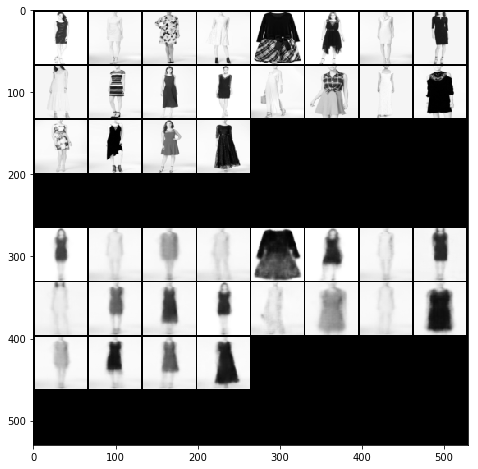

In [33]:
import numpy as np
# Plot reconstructions
%matplotlib inline
import matplotlib.pyplot as plt

# Get a batch of data
for batch, labels in test_loader:
    break

# Reconstruct data using Joint-VAE model
recon = viz.reconstructions(batch)

# plt.figure(figsize=(8,8))
# plt.imshow(recon.numpy()[0, :, :], cmap='gray');
plt.figure(figsize=(22,22))
plt.imshow(np.rot90(np.transpose(recon.numpy(),(2,1,0)),k=3));
plt.savefig("sample_images/308/64/e200_b20_reconstructions.png",dpi=600)

In [ ]:
# Plot samples
samples = viz.samples()

plt.figure(figsize=(8,8))
plt.imshow(samples.numpy()[0, :, :], cmap='gray');

In [ ]:
# Plot all traversals
traversals = viz.all_latent_traversals(size=10)

plt.figure(figsize=(8,8))
plt.imshow(traversals.numpy()[0, :, :], cmap='gray');

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(8,8))
plt.imshow(traversals.numpy()[0, :, :], cmap='gray');

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=1, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(8,8))
plt.imshow(traversals.numpy()[0, :, :], cmap='gray');

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=9, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(8,8))
plt.imshow(traversals.numpy()[0, :, :], cmap='gray');

### Save Model

In [ ]:
model_name = "jvae_fmnist_oct292018.pth"

In [ ]:
torch.save(model.state_dict(),"statedict_" + model_name) # save state dict
torch.save(model, model_name) # save full model

#### Restore Model from State Dict

In [ ]:
sd_model = VAE(latent_spec=latent_spec, img_size=(1, 32, 32))
sd_model.load_state_dict(torch.load("statedict_" + model_name))

#### Restore Full Model
* Note in this case the serialized data is bound to the specific classes and exact directory strucutre used.

In [ ]:
full_model = torch.load(model_name)

In [ ]:
type(full_model)

In [ ]:
type(sd_model)